In [ ]:
#SEED ALL for reproducibility
from numpy.random import seed
import tensorflow as tf
import random

cherrypicked_seed = 42

seed(cherrypicked_seed)
tf.random.set_seed(cherrypicked_seed)
random.seed(cherrypicked_seed)

# Predicting Multi-MNIST digits.

The assignment consists of two tasks:

1. A multi-class classification problem: the prediction of grayscale images of double-digit numbers from a custom version of the (Multi-)MNIST dataset.

2. Unsupervised problem: the implementation of an AutoEncoder model for the encoding and reconstruction of the provided data.

The dataset is created by simply concatenating pairs of MNIST digits, and the number of classes (originally all the numbers in the [0, 100] range) has been reduced.

An example of the provided dataset is the following:

![img](https://raw.githubusercontent.com/DBertazioli/multi-mnist_custom/master/examples/test_example.png)


**General considerations**

Always describe and give proper motivations about the choices made during the assignment, including (but not limited to)

- data processing, 
- network design: including number and dimension of the layers, regularization techniques (when requested).
- optimization algorithms, including hyperameters and criterions, 
- model training hyperparameters
- loss/metric curves
- final evaluations and comparisons.


**Note**: Make sure that the outputs in the notebook cells are still visible once the notebook is exported (especially for html embeddings)

**Note**: Make sure that the submitted *.zip archives are not corrupted.

**Note**: convolutional layers should not be used all over this notebook (with the exception of the optional part).

# 0. Dataset

The provided data comprises the training set that can be used for the training (and for the validation) and the test set.

The data can be loaded as follows:


In [ ]:
!wget https://github.com/DBertazioli/multi-mnist_custom/raw/master/final_dataset/X_train.npz
!wget https://github.com/DBertazioli/multi-mnist_custom/raw/master/final_dataset/y_train.npz
!wget https://github.com/DBertazioli/multi-mnist_custom/raw/master/final_dataset/X_test.npz
!wget https://github.com/DBertazioli/multi-mnist_custom/raw/master/final_dataset/y_test.npz

--2022-11-26 23:38:21--  https://github.com/DBertazioli/multi-mnist_custom/raw/master/final_dataset/X_train.npz
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/DBertazioli/multi-mnist_custom/master/final_dataset/X_train.npz [following]
--2022-11-26 23:38:22--  https://raw.githubusercontent.com/DBertazioli/multi-mnist_custom/master/final_dataset/X_train.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30289992 (29M) [application/octet-stream]
Saving to: ‘X_train.npz’

X_train.npz         100%[===================>]  28.89M  --.-KB/s    in 0.1s    

2022-11-26 23:38:22 (288 MB/s) - ‘X_train.npz’

In [ ]:
import numpy as np

X_train = np.load("X_train.npz")["arr_0"]
y_train = np.load("y_train.npz")["arr_0"]

X_test = np.load("X_test.npz")["arr_0"]
y_test = np.load("y_test.npz")["arr_0"]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((83551, 28, 39), (83551,), (12779, 28, 39), (12779,))

##Inspecting the data

We have reasonable amount of data (that is way more than in the orginal mnist dataset), 83551 samples in training set and 12779 in test set should be enough, so hopefully we don't need data augmenatation. Also important to mantion is that the pictures are 28x34 pixels, unlike in the previous dataset.

In [ ]:
X_train[0], y_train[0], X_test[0], y_test[0]

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 42,
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 19)

In [ ]:
type(X_train[0]), type(y_train[0]), type(X_test[0]), type(y_test[0])

(numpy.ndarray, numpy.int64, numpy.ndarray, numpy.int64)

In [ ]:
import matplotlib.pyplot as plt

# function to plot a image
def plot_image(image, is_flatten=False):
  if is_flatten:
    image = image.reshape(28, 39)
  plt.imshow(image, cmap='gray')
  plt.axis('off')
  plt.show()

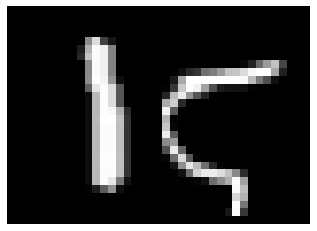

In [ ]:
# looking at a plot of a sample
plot_image(X_train[3])

In [ ]:
import itertools
flatten_X = []

# each image is represanted by matrix 28 by 39 pixels
# we want to normilize it 
# or later to perform machine learning 
# it is better to have it flatten

for image in itertools.chain(X_train, X_test):
  flatten_X.append(image.flatten())

flatten_X = np.array(flatten_X)
flatten_X.shape

(96330, 1092)

In [ ]:
import pandas as pd

In [ ]:
df_X = pd.DataFrame(flatten_X)
df_X.head()

,0,1,2,3,4,5,6,7,8,9,...,1082,1083,1084,1085,1086,1087,1088,1089,1090,1091
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_X.describe()

,0,1,2,3,4,5,6,7,8,9,...,1082,1083,1084,1085,1086,1087,1088,1089,1090,1091
count,96330.0,96330.0,96330.0,96330.0,96330.0,96330.0,96330.0,96330.0,96330.0,96330.0,...,96330.000000,96330.000000,96330.000000,96330.00000,96330.000000,96330.000000,96330.0,96330.0,96330.0,96330.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.149320,0.073144,0.031143,0.01363,0.005533,0.000301,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.071276,3.438820,2.121683,1.27540,0.743473,0.093437,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,251.000000,252.000000,252.000000,189.00000,165.000000,29.000000,0.0,0.0,0.0,0.0


In fact, that is not what I wanted to obtain, but we can see that the first and the last pixels are always equal to 0. We can do some dimensionality reduction if the results won't meet expectations.

In [ ]:
df_X = df_X.transpose()
df_X.describe()

,0,1,2,3,4,5,6,7,8,9,...,96320,96321,96322,96323,96324,96325,96326,96327,96328,96329
count,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,...,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000
mean,52.994505,50.543040,55.005495,27.888278,41.999084,45.869048,33.860806,40.810440,33.701465,39.222527,...,58.618132,39.306777,24.336996,55.300366,53.677656,63.428571,37.854396,42.792125,62.025641,51.464286
std,95.433489,90.090071,92.313666,69.012800,79.588383,86.507807,73.535596,82.603543,74.043901,77.134858,...,96.938157,80.424357,59.639968,91.376787,92.227196,99.570846,77.856268,80.961261,98.449963,95.989342
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,45.000000,58.000000,79.250000,0.000000,29.250000,37.250000,3.000000,9.000000,0.000000,23.000000,...,96.750000,8.250000,0.000000,96.250000,69.250000,124.000000,8.000000,33.750000,115.250000,25.250000
max,255.000000,255.000000,255.000000,254.000000,254.000000,255.000000,254.000000,255.000000,255.000000,254.000000,...,254.000000,253.000000,255.000000,254.000000,255.000000,255.000000,254.000000,254.000000,254.000000,255.000000


The most important to notice here- each pixel have value between 0 and 255.

In [ ]:
np.min(y_train), np.max(y_train)

(1, 50)

(array([2780.,  135., 2463., 2368., 2211.,  592., 2548.,  486., 2469.,
        2807., 3112.,  720.,  161.,  557., 2499., 2709.,  130.,  306.,
        2890., 2403.,  564., 2433., 2508.,  311.,  547., 2450., 2575.,
        2370., 2451.,  135.,  711.,  851., 2609., 2485., 2313., 2568.,
         376.,  827.,  286., 2435.,  309., 2318.,  117., 2363., 2199.,
        2454., 2560.,  488., 2417., 2175.]),
 array([ 1.  ,  1.98,  2.96,  3.94,  4.92,  5.9 ,  6.88,  7.86,  8.84,
         9.82, 10.8 , 11.78, 12.76, 13.74, 14.72, 15.7 , 16.68, 17.66,
        18.64, 19.62, 20.6 , 21.58, 22.56, 23.54, 24.52, 25.5 , 26.48,
        27.46, 28.44, 29.42, 30.4 , 31.38, 32.36, 33.34, 34.32, 35.3 ,
        36.28, 37.26, 38.24, 39.22, 40.2 , 41.18, 42.16, 43.14, 44.12,
        45.1 , 46.08, 47.06, 48.04, 49.02, 50.  ]),
 <a list of 50 Patch objects>)

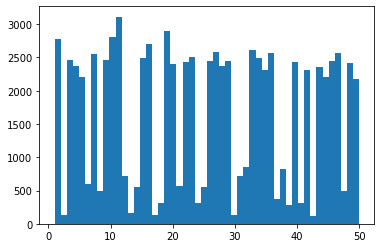

In [ ]:
plt.hist(y_train, bins=50)

(array([303., 234., 224., 249., 214., 237., 251., 259., 244., 275., 312.,
        307., 279., 279., 243., 256., 298., 295., 269., 251., 292., 266.,
        266., 243., 208., 248., 282., 222., 249., 245., 315., 245., 255.,
        267., 207., 238., 260., 234., 265., 255., 287., 258., 249., 243.,
        220., 240., 264., 211., 259., 207.]),
 array([ 1.  ,  1.98,  2.96,  3.94,  4.92,  5.9 ,  6.88,  7.86,  8.84,
         9.82, 10.8 , 11.78, 12.76, 13.74, 14.72, 15.7 , 16.68, 17.66,
        18.64, 19.62, 20.6 , 21.58, 22.56, 23.54, 24.52, 25.5 , 26.48,
        27.46, 28.44, 29.42, 30.4 , 31.38, 32.36, 33.34, 34.32, 35.3 ,
        36.28, 37.26, 38.24, 39.22, 40.2 , 41.18, 42.16, 43.14, 44.12,
        45.1 , 46.08, 47.06, 48.04, 49.02, 50.  ]),
 <a list of 50 Patch objects>)

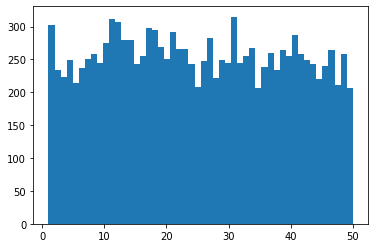

In [ ]:
plt.hist(y_test, bins=50)


Since y_train is not well distributed, I will concatenate the sets and divide them later with train_test_split, hoping to get more equal distribution.

(array([3083.,  369., 2687., 2617., 2425.,  829., 2799.,  745., 2713.,
        3082., 3424., 1027.,  440.,  836., 2742., 2965.,  428.,  601.,
        3159., 2654.,  856., 2699., 2774.,  554.,  755., 2698., 2857.,
        2592., 2700.,  380., 1026., 1096., 2864., 2752., 2520., 2806.,
         636., 1061.,  551., 2690.,  596., 2576.,  366., 2606., 2419.,
        2694., 2824.,  699., 2676., 2382.]),
 array([ 1.  ,  1.98,  2.96,  3.94,  4.92,  5.9 ,  6.88,  7.86,  8.84,
         9.82, 10.8 , 11.78, 12.76, 13.74, 14.72, 15.7 , 16.68, 17.66,
        18.64, 19.62, 20.6 , 21.58, 22.56, 23.54, 24.52, 25.5 , 26.48,
        27.46, 28.44, 29.42, 30.4 , 31.38, 32.36, 33.34, 34.32, 35.3 ,
        36.28, 37.26, 38.24, 39.22, 40.2 , 41.18, 42.16, 43.14, 44.12,
        45.1 , 46.08, 47.06, 48.04, 49.02, 50.  ]),
 <a list of 50 Patch objects>)

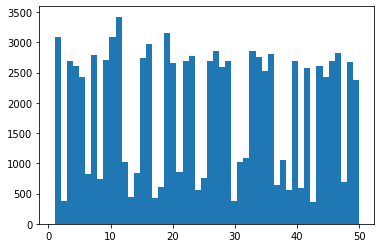

In [ ]:
y = np.concatenate((y_train,y_test))
plt.hist(y, bins=50)

The numbers aren't equally distributed and they are values from 1 to 50. That may be a problem while getting optimal classification results.

## Preparing the data


In [ ]:
np.min(flatten_X), np.max(flatten_X)

(0, 255)

In [ ]:
# in the cell above we see that the pixel values are from 0-255
# we want to rescale it to 0.0-1.0
from sklearn.preprocessing import MinMaxScaler

# we use min-max-scaler
# in fact that would be the same if we devided the values by 255
scaler = MinMaxScaler()

flatten_X = scaler.fit_transform(flatten_X)

In [ ]:
np.min(flatten_X), np.max(flatten_X)

(0.0, 1.0)

Before I will do train_test_split(), I want to make sure that the data is still labeled properly by looking at some examples.

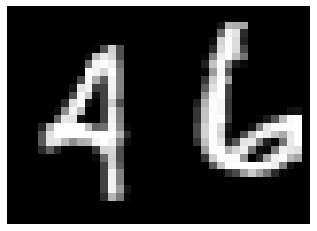

(None, 46)

In [ ]:
plot_image(flatten_X[45], is_flatten=True), y[45]

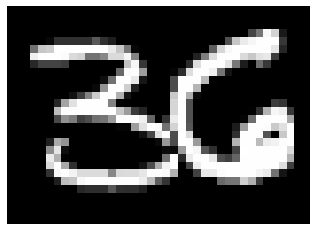

(None, 36)

In [ ]:
plot_image(flatten_X[90000], is_flatten=True), y[90000]

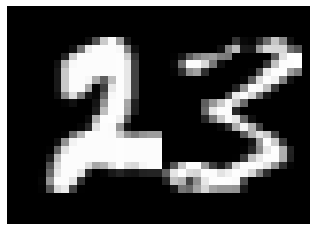

(None, 23)

In [ ]:
plot_image(flatten_X[91000], is_flatten=True), y[91000]

In [ ]:
# later I have made a nice function to subplot more of those with random indcies
# so I am going to use it here as well
subplot_images(flatten_X, y, n_images=9)

Everything alright.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(flatten_X, y, test_size = 0.2)

(array([2505.,  303., 2113., 2087., 1945.,  674., 2248.,  581., 2172.,
        2432., 2762.,  819.,  355.,  655., 2209., 2372.,  337.,  470.,
        2525., 2143.,  705., 2152., 2218.,  434.,  584., 2169., 2295.,
        2079., 2173.,  306.,  846.,  872., 2293., 2177., 2029., 2250.,
         507.,  861.,  436., 2191.,  474., 2032.,  296., 2089., 1920.,
        2163., 2232.,  566., 2121., 1887.]),
 array([ 1.  ,  1.98,  2.96,  3.94,  4.92,  5.9 ,  6.88,  7.86,  8.84,
         9.82, 10.8 , 11.78, 12.76, 13.74, 14.72, 15.7 , 16.68, 17.66,
        18.64, 19.62, 20.6 , 21.58, 22.56, 23.54, 24.52, 25.5 , 26.48,
        27.46, 28.44, 29.42, 30.4 , 31.38, 32.36, 33.34, 34.32, 35.3 ,
        36.28, 37.26, 38.24, 39.22, 40.2 , 41.18, 42.16, 43.14, 44.12,
        45.1 , 46.08, 47.06, 48.04, 49.02, 50.  ]),
 <a list of 50 Patch objects>)

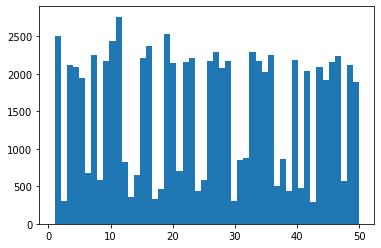

In [ ]:
plt.hist(y_train, bins=50)

(array([578.,  66., 574., 530., 480., 155., 551., 164., 541., 650., 662.,
        208.,  85., 181., 533., 593.,  91., 131., 634., 511., 151., 547.,
        556., 120., 171., 529., 562., 513., 527.,  74., 180., 224., 571.,
        575., 491., 556., 129., 200., 115., 499., 122., 544.,  70., 517.,
        499., 531., 592., 133., 555., 495.]),
 array([ 1.  ,  1.98,  2.96,  3.94,  4.92,  5.9 ,  6.88,  7.86,  8.84,
         9.82, 10.8 , 11.78, 12.76, 13.74, 14.72, 15.7 , 16.68, 17.66,
        18.64, 19.62, 20.6 , 21.58, 22.56, 23.54, 24.52, 25.5 , 26.48,
        27.46, 28.44, 29.42, 30.4 , 31.38, 32.36, 33.34, 34.32, 35.3 ,
        36.28, 37.26, 38.24, 39.22, 40.2 , 41.18, 42.16, 43.14, 44.12,
        45.1 , 46.08, 47.06, 48.04, 49.02, 50.  ]),
 <a list of 50 Patch objects>)

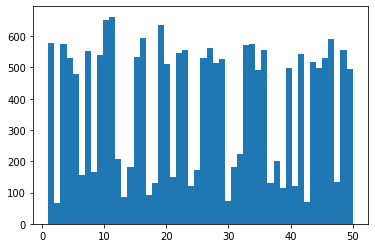

In [ ]:
plt.hist(y_test, bins=50)

Now both (y_train and y_test) are not equally distribute, but at least it is fair :)
I will try with diffrent splits, but it may be hard to evaluate, since it will affect the X_test...

In [ ]:
from tensorflow.keras.utils import to_categorical

# one hot encoding on the labels
# we add one to 50 because with one hot
# we have to consider zero since the indexing starts with it
y_train_one_hot = to_categorical(y_train, num_classes=51)
y_test_one_hot = to_categorical(y_test, num_classes=51)

In [ ]:
y_test.shape, y_test_one_hot.shape

((19266,), (19266, 51))

# 1. The resolution of the problem of supervised classification with traditional fully-connected neural networks. [Mandatory]





You are required to implement two models, without and with the use of one (or more) regularization technique of your choice, and to compare their behaviours, in terms of training dynamics and generalization capabilities.

**Important Constraint**: all the models implemented in section 1. (and its subsections) must have **less than 100'000 trainable parameters**.

## 1.1 Non-regularized Model

In this section, you are required to attempt to solve the classification task with the implementation and training of a standard fully-connected Neural Network, without the use of any specific regularization technique.

### 1.1.1 Building the network


any description/comment about the procedure you followed in the choice of the network structure and hyperparameters goes here, together with consideration about the training/optimization procedure (e.g. loss/optimizer choice, final activations, loss functions, training metrics and training hyperparameters)

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import L2
from tensorflow.keras.metrics import Precision, Recall

In [ ]:
input_size = 28*39
n_epochs = 20
n_neurons = 75

In [ ]:
model = Sequential()

# I decided to choose rectangular architecture, 
# because we cannot have too big number of neurons (100 000 constraint)
# in the frist layer cause it rises the number of parameters to much 
# and I don't want to have lower number of neurons in hidden layers than the number of classes (50)
# EDIT: Apparently I could have fewer neurons in the layer than classes 
# but I obtained good results with the other approach so I am leaving it by now

# relu as a default choise 
# softmax since it is multi-class classifiaction
model.add(Dense(n_neurons, activation='relu', input_shape=(input_size,)))
model.add(Dense(n_neurons, activation='relu'))
model.add(Dense(n_neurons, activation='relu'))

model.add(Dense(51, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 75)                81975     
                                                                 
 dense_1 (Dense)             (None, 75)                5700      
                                                                 
 dense_2 (Dense)             (None, 75)                5700      
                                                                 
 dense_3 (Dense)             (None, 51)                3876      
                                                                 
Total params: 97,251
Trainable params: 97,251
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# categorical cross-entropy it is an obvious decision
# same for the accuracy
# I added also precision and recall to compere models better
# adam also became the default option for me, usually has been working the best for me
model.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy', Precision(), Recall()], optimizer='adam')

In [ ]:
# validation split- default
# epochs- it quite complex problem, input layer of size 1 092 
# so the epochs number no too big
# I started with 50 but it was taking to long and how it is 20 
# batch size- I have tried diffrent options and that one is just good enough
# the oscillation aren't too big
history = model.fit(X_train, y_train_one_hot, validation_split=0.1, epochs=n_epochs, batch_size=64)

Epoch 1/20
1084/1084 [==============================] - 6s 5ms/step - loss: 3.1492 - categorical_accuracy: 0.3084 - precision_4: 0.6419 - recall_4: 0.1827 - val_loss: 1.7055 - val_categorical_accuracy: 0.5076 - val_precision_4: 0.7475 - val_recall_4: 0.3157
Epoch 2/20
1084/1084 [==============================] - 5s 5ms/step - loss: 1.3646 - categorical_accuracy: 0.6047 - precision_4: 0.7677 - recall_4: 0.4737 - val_loss: 1.2342 - val_categorical_accuracy: 0.6537 - val_precision_4: 0.7730 - val_recall_4: 0.5447
Epoch 3/20
1084/1084 [==============================] - 5s 5ms/step - loss: 1.0966 - categorical_accuracy: 0.6791 - precision_4: 0.8047 - recall_4: 0.5699 - val_loss: 1.0717 - val_categorical_accuracy: 0.6820 - val_precision_4: 0.7998 - val_recall_4: 0.5810
Epoch 4/20
1084/1084 [==============================] - 6s 5ms/step - loss: 0.9969 - categorical_accuracy: 0.7041 - precision_4: 0.8130 - recall_4: 0.6051 - val_loss: 0.9691 - val_categorical_accuracy: 0.7153 - val_precision_4

### 1.1.2 Analyze and comment on thetraining results


In [ ]:
# code reusage ;)
# I am using this function instead of tensorboard bacause
# it is enough and it is easier to share for evaluation

x_plot = list(range(1,n_epochs+1))

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history.history['categorical_accuracy'])
    plt.plot(x_plot, network_history.history['val_categorical_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

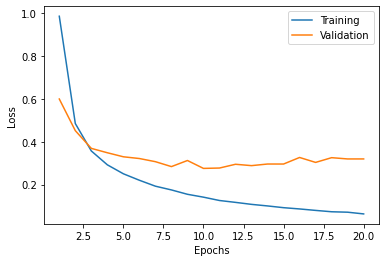

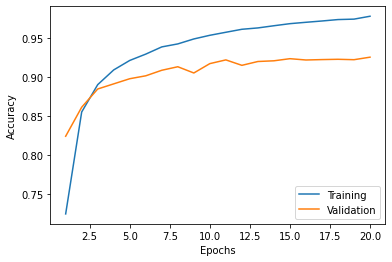

In [ ]:
plot_history(history)

In [ ]:
model.evaluate(X_test, y_test_one_hot), model.metrics_names

603/603 [==============================] - 2s 4ms/step - loss: 0.3356 - categorical_accuracy: 0.9236 - precision: 0.9273 - recall: 0.9220


([0.33564358949661255,
  0.9235959649085999,
  0.9273334741592407,
  0.9220388531684875],
 ['loss', 'categorical_accuracy', 'precision', 'recall'])

#### Conclusions
I notice a slide rise of the loss function on the validation set, so maybe reducing the number of epochs even more, would be a good idea. But we perform well on the test set as it is. I believe that regularisation methods will help with rising loss. 

### 1.1.3 Validate the model and comment on theresults

please describe and interpret the evaluation procedure on a **validation set**, including initial comments on the generalization capability of your model (e.g. under/overfitting). 

You may also describe the performance metrics that you choose: what is the most suitable performance measure (or set of performance measures) in this case/dataset, according to you? Why?

In [ ]:
y_pred_test = model.predict(X_test)

603/603 [==============================] - 1s 2ms/step


In [ ]:
# funtion to subplot a few images at the same time
def subplot_images(X, y_orginal, y_predicted=None,  n_images=9):
  indecies = np.random.randint(X.shape[0], size=n_images)
  n = np.sqrt(n_images).astype('int')
  fig, axs = plt.subplots(n, n)
  fig.set_dpi(n*50)
  for i in range(n):
    for j in range(n):
      index = indecies[i*n + j]
      axs[i, j].imshow(X[index].reshape(28,39))
      if y_predicted is not None:
        axs[i, j].set_title(f'Predicted: {y_predicted[index]}, orginal: {y_orginal[index]}',
                            {'fontsize': 6})
      else:
        axs[i, j].set_title(f'orginal: {y_orginal[index]}',
                            {'fontsize': 6})
      axs[i, j].axis('off')

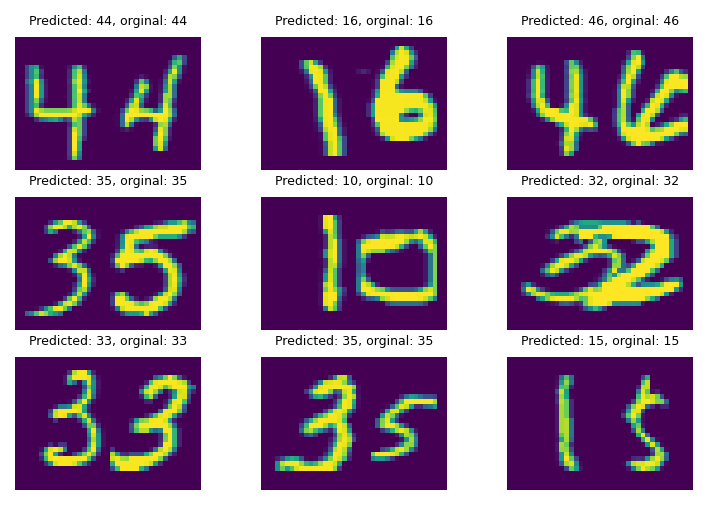

In [ ]:
subplot_images(X_test, y_test_one_hot, y_pred_test, n_images=9)

As we can see, in most cases it is doing well. I am quite surprised by that fact, I thought it will be harder with the parameter constraint (that is why I plotted many images, I couldn't belive it). But nothing to worry about :) 

In [ ]:
y_not_one_hot_test = [np.argmax(one_hot) for one_hot in y_test_one_hot]
y_not_one_hot_pred = [np.argmax(one_hot) for one_hot in y_pred_test]

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

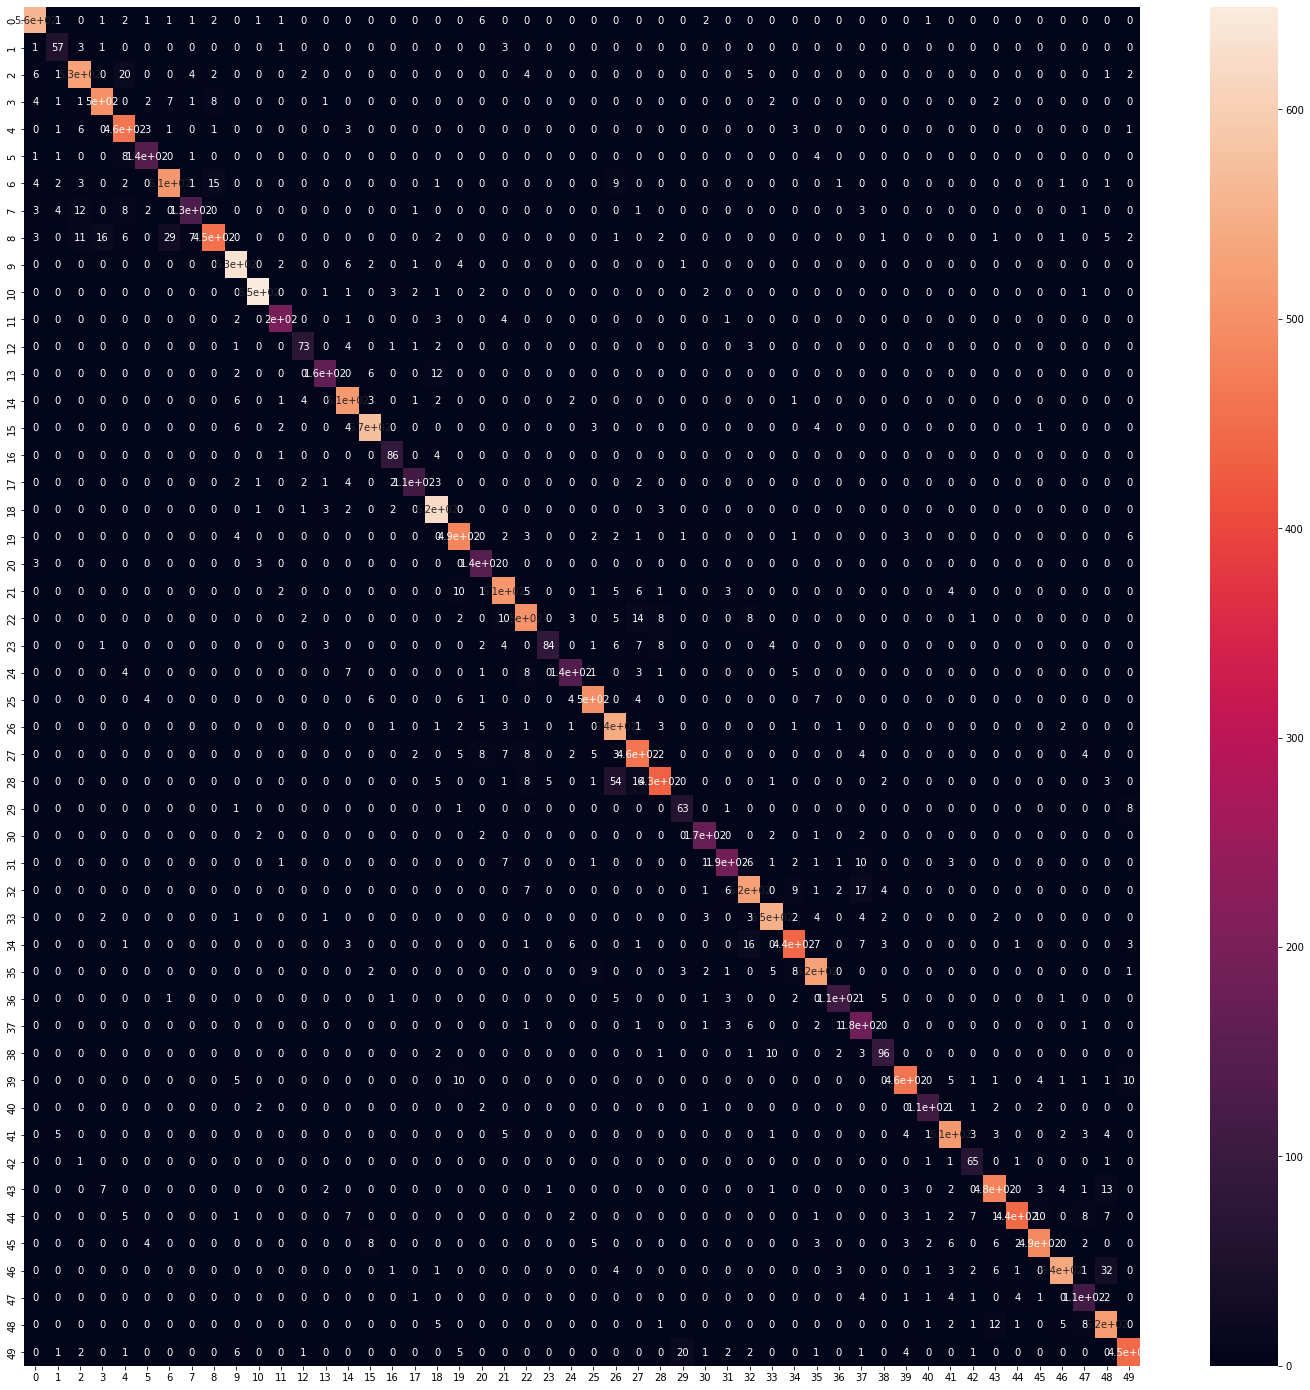

In [ ]:
plt.figure(figsize=(25,25))

CM = confusion_matrix(y_not_one_hot_test, y_not_one_hot_pred)
df_cm = pd.DataFrame(CM, index = [i for i in range(50)],
                  columns = [i for i in range(50)])

sn.heatmap(df_cm, annot=True)

One needs a big screen to analyze it. Nevertheless, two things to notice:
- The matrix has huge values on the diagonal and lower in the other parts, good information
- The mistakes are understandable. For example, 06 or 21 was predicted as 26, but zero can get similar to two, as well as one can get similar to 6. I claim that the mistakes are because of illegible writing, rather than network "mistakes".

## 1.2 Regularized Model

In [ ]:
modelR = Sequential()

input_size = 28*39
n_epochs = 20
n_neurons = 75
 
# I have the same architecture in this model since then we can really compare the results
# FIRST TRY: L2 reguralization cause I find it better that L1 
# it penalize bit weigth more so I think usually it is better
# I penelize the first layers more cause and then reduce
# the alfa by dividing it by 10
modelR.add(Dense(n_neurons, activation='relu', input_shape=(input_size,), kernel_regularizer=L2(0.001)))
modelR.add(Dense(n_neurons, activation='relu', kernel_regularizer=L2(0.00001)))
modelR.add(Dense(n_neurons, activation='relu', kernel_regularizer=L2(0.000001)))

modelR.add(Dense(51, activation='softmax'))

modelR.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 75)                81975     
                                                                 
 dense_49 (Dense)            (None, 75)                5700      
                                                                 
 dense_50 (Dense)            (None, 75)                5700      
                                                                 
 dense_51 (Dense)            (None, 51)                3876      
                                                                 
Total params: 97,251
Trainable params: 97,251
Non-trainable params: 0
_________________________________________________________________


In [ ]:
modelR.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy', Precision(), Recall()], optimizer='adam')

In [ ]:
historyR = modelR.fit(X_train, y_train_one_hot, validation_split=0.1, epochs=n_epochs, batch_size=64)

Epoch 1/20
1084/1084 [==============================] - 11s 9ms/step - loss: 1.0799 - categorical_accuracy: 0.7308 - precision_11: 0.8603 - recall_11: 0.6289 - val_loss: 0.7147 - val_categorical_accuracy: 0.8193 - val_precision_11: 0.8760 - val_recall_11: 0.7633
Epoch 2/20
1084/1084 [==============================] - 8s 7ms/step - loss: 0.5923 - categorical_accuracy: 0.8567 - precision_11: 0.8975 - recall_11: 0.8198 - val_loss: 0.5818 - val_categorical_accuracy: 0.8551 - val_precision_11: 0.8878 - val_recall_11: 0.8243
Epoch 3/20
1084/1084 [==============================] - 8s 8ms/step - loss: 0.4798 - categorical_accuracy: 0.8865 - precision_11: 0.9160 - recall_11: 0.8624 - val_loss: 0.5155 - val_categorical_accuracy: 0.8717 - val_precision_11: 0.9012 - val_recall_11: 0.8473
Epoch 4/20
1084/1084 [==============================] - 8s 7ms/step - loss: 0.4237 - categorical_accuracy: 0.9009 - precision_11: 0.9236 - recall_11: 0.8817 - val_loss: 0.4574 - val_categorical_accuracy: 0.8933 - 

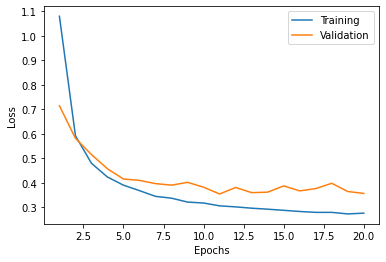

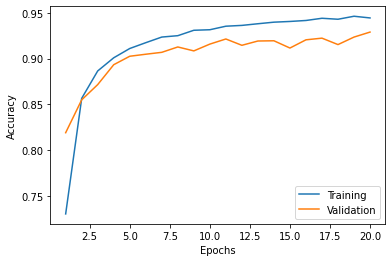

In [ ]:
x_plot = list(range(1,n_epochs+1))
plot_history(historyR)

## 1.3. Compare the performances of the two models (non-regularized and regularized) on the provided test set, visualize and comment on theresults




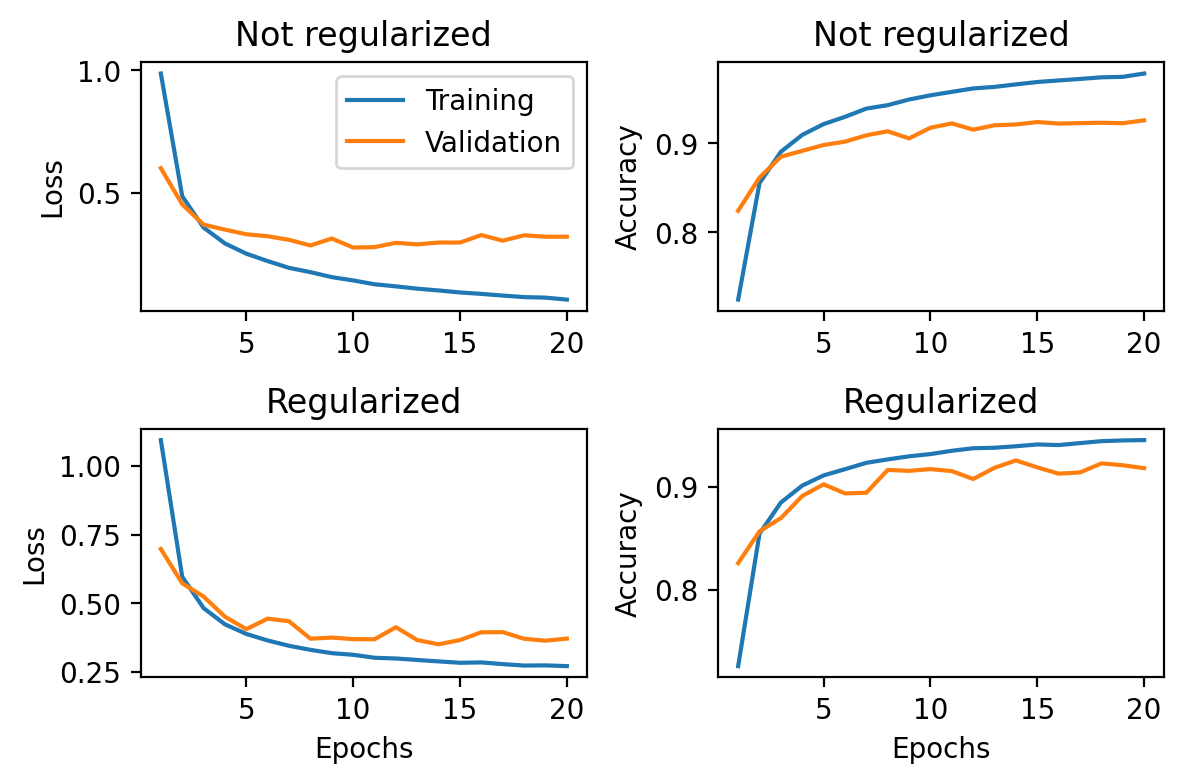

In [ ]:
fig, axs = plt.subplots(2, 2)
    
fig.set_dpi(200)
x_plot = list(range(1,n_epochs+1))

axs[0, 0].set_title('Not regularized')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].plot(x_plot, history.history['loss'])
axs[0, 0].plot(x_plot, history.history['val_loss'])
axs[0, 0].legend(['Training', 'Validation'])

axs[0, 1].set_title('Not regularized')
axs[0, 1].set_ylabel('Accuracy')
axs[0, 1].plot(x_plot, history.history['categorical_accuracy'])
axs[0, 1].plot(x_plot, history.history['val_categorical_accuracy'])

axs[1, 0].set_title('Regularized')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].plot(x_plot, historyR.history['loss'])
axs[1, 0].plot(x_plot, historyR.history['val_loss'])

axs[1, 1].set_title('Regularized')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].plot(x_plot, historyR.history['categorical_accuracy'])
axs[1, 1].plot(x_plot, historyR.history['val_categorical_accuracy'])

fig.tight_layout(pad=1.0)

In [ ]:
df_evaluate = pd.DataFrame([model.evaluate(X_test, y_test_one_hot), modelR.evaluate(X_test, y_test_one_hot)], columns=model.metrics_names, 
                           index=['not regularized', 'regularized'])

df_evaluate

603/603 [==============================] - 2s 4ms/step - loss: 0.3659 - categorical_accuracy: 0.9219 - precision_1: 0.9329 - recall_1: 0.9133


,loss,categorical_accuracy,precision,recall
not regularized,0.335644,0.923596,0.927333,0.922039
regularized,0.365928,0.921883,0.932881,0.913319


I expected to eliminate the rising loss function, which could mean, overfitting and I have obtained it. Even with the overfitting, the first model was doing quite well on the test set so it wasn't a very big one. The modelR might be slightly underfitted, so to observe overfitting in the first one better and get rid of underfitting we learn the same model but for 40 epochs now. It will increase the contrast between two models.


In [ ]:
n_epochs = 40

In [ ]:
model_more_epochs = Sequential()

model_more_epochs.add(Dense(n_neurons, activation='relu', input_shape=(input_size,)))
model_more_epochs.add(Dense(n_neurons, activation='relu'))
model_more_epochs.add(Dense(n_neurons, activation='relu'))

model_more_epochs.add(Dense(51, activation='softmax'))

model_more_epochs.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 75)                81975     
                                                                 
 dense_41 (Dense)            (None, 75)                5700      
                                                                 
 dense_42 (Dense)            (None, 75)                5700      
                                                                 
 dense_43 (Dense)            (None, 51)                3876      
                                                                 
Total params: 97,251
Trainable params: 97,251
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_more_epochs.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy', Precision(), Recall()], optimizer='adam')

In [ ]:
history_more_epochs = model_more_epochs.fit(X_train, y_train_one_hot, validation_split=0.1, epochs=n_epochs, batch_size=64)

Epoch 1/40
1084/1084 [==============================] - 8s 6ms/step - loss: 0.9529 - categorical_accuracy: 0.7346 - precision_9: 0.8602 - recall_9: 0.6350 - val_loss: 0.5807 - val_categorical_accuracy: 0.8307 - val_precision_9: 0.8825 - val_recall_9: 0.7837
Epoch 2/40
1084/1084 [==============================] - 6s 6ms/step - loss: 0.4654 - categorical_accuracy: 0.8611 - precision_9: 0.8990 - recall_9: 0.8286 - val_loss: 0.4383 - val_categorical_accuracy: 0.8622 - val_precision_9: 0.8980 - val_recall_9: 0.8372
Epoch 3/40
1084/1084 [==============================] - 6s 6ms/step - loss: 0.3516 - categorical_accuracy: 0.8929 - precision_9: 0.9175 - recall_9: 0.8721 - val_loss: 0.3789 - val_categorical_accuracy: 0.8821 - val_precision_9: 0.9041 - val_recall_9: 0.8621
Epoch 4/40
1084/1084 [==============================] - 6s 6ms/step - loss: 0.2901 - categorical_accuracy: 0.9120 - precision_9: 0.9308 - recall_9: 0.8965 - val_loss: 0.3462 - val_categorical_accuracy: 0.8915 - val_precision_9

In [ ]:
modelR_more_epochs = Sequential()

modelR_more_epochs.add(Dense(n_neurons, activation='relu', input_shape=(input_size,), kernel_regularizer=L2(0.001)))
modelR_more_epochs.add(Dense(n_neurons, activation='relu', kernel_regularizer=L2(0.00001)))
modelR_more_epochs.add(Dense(n_neurons, activation='relu', kernel_regularizer=L2(0.000001)))

modelR_more_epochs.add(Dense(51, activation='softmax'))

modelR_more_epochs.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 75)                81975     
                                                                 
 dense_45 (Dense)            (None, 75)                5700      
                                                                 
 dense_46 (Dense)            (None, 75)                5700      
                                                                 
 dense_47 (Dense)            (None, 51)                3876      
                                                                 
Total params: 97,251
Trainable params: 97,251
Non-trainable params: 0
_________________________________________________________________


In [ ]:
modelR_more_epochs.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy', Precision(), Recall()], optimizer='adam')

In [ ]:
historyR_more_epochs = modelR_more_epochs.fit(X_train, y_train_one_hot, validation_split=0.1, epochs=n_epochs, batch_size=64)

Epoch 1/40
1084/1084 [==============================] - 9s 7ms/step - loss: 1.0829 - categorical_accuracy: 0.7253 - precision_10: 0.8608 - recall_10: 0.6255 - val_loss: 0.7039 - val_categorical_accuracy: 0.8194 - val_precision_10: 0.8772 - val_recall_10: 0.7668
Epoch 2/40
1084/1084 [==============================] - 7s 6ms/step - loss: 0.5911 - categorical_accuracy: 0.8562 - precision_10: 0.8987 - recall_10: 0.8194 - val_loss: 0.5731 - val_categorical_accuracy: 0.8560 - val_precision_10: 0.8946 - val_recall_10: 0.8270
Epoch 3/40
1084/1084 [==============================] - 7s 6ms/step - loss: 0.4729 - categorical_accuracy: 0.8875 - precision_10: 0.9158 - recall_10: 0.8627 - val_loss: 0.4831 - val_categorical_accuracy: 0.8775 - val_precision_10: 0.9042 - val_recall_10: 0.8565
Epoch 4/40
1084/1084 [==============================] - 7s 6ms/step - loss: 0.4127 - categorical_accuracy: 0.9037 - precision_10: 0.9245 - recall_10: 0.8853 - val_loss: 0.4455 - val_categorical_accuracy: 0.8920 - v

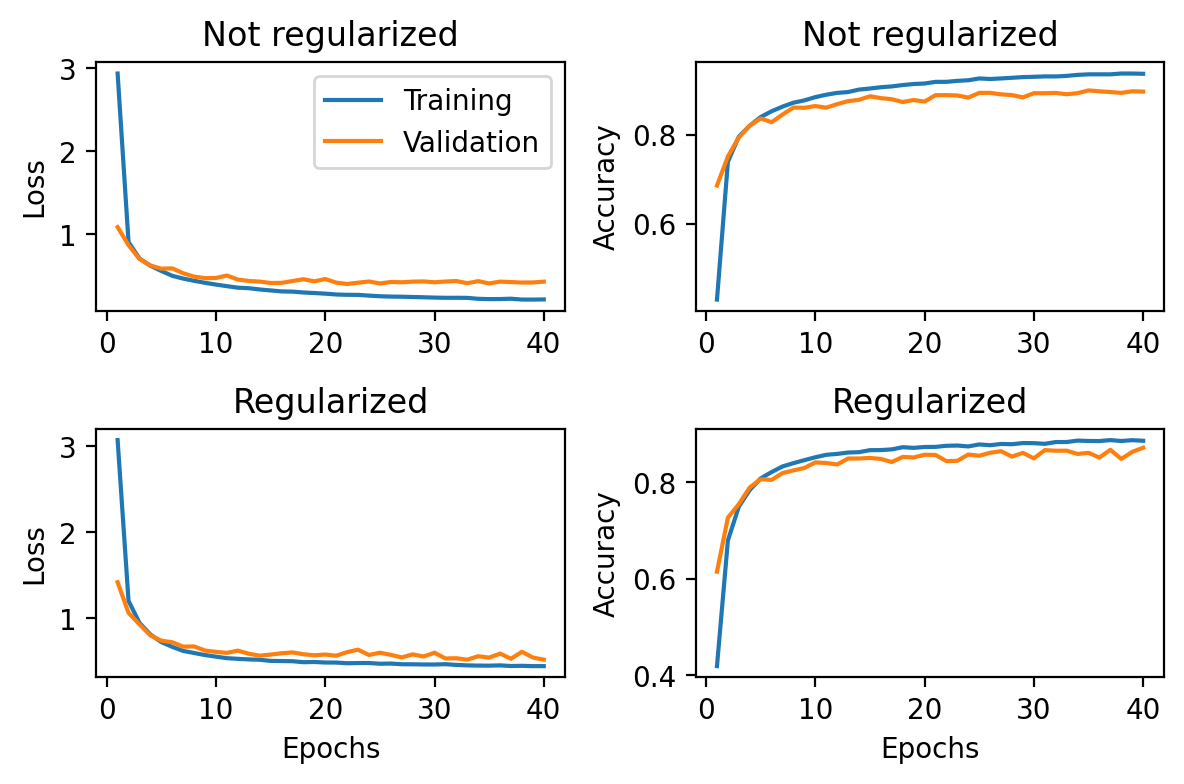

In [ ]:
fig, axs = plt.subplots(2, 2)
    
fig.set_dpi(200)
# now we have 2xn_epochs 
x_plot = list(range(1,n_epochs + 1))

# adding to each plot history_2 to extend the plot
axs[0, 0].set_title('Not regularized')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].plot(x_plot, history_more_epochs.history['loss'])
axs[0, 0].plot(x_plot, history_more_epochs.history['val_loss'])
axs[0, 0].legend(['Training', 'Validation'])

axs[0, 1].set_title('Not regularized')
axs[0, 1].set_ylabel('Accuracy')
axs[0, 1].plot(x_plot, history_more_epochs.history['categorical_accuracy'])
axs[0, 1].plot(x_plot, history_more_epochs.history['val_categorical_accuracy'])

axs[1, 0].set_title('Regularized')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].plot(x_plot, historyR_more_epochs.history['loss'])
axs[1, 0].plot(x_plot, historyR_more_epochs.history['val_loss'])

axs[1, 1].set_title('Regularized')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].plot(x_plot, historyR_more_epochs.history['categorical_accuracy'])
axs[1, 1].plot(x_plot, historyR_more_epochs.history['val_categorical_accuracy'])

fig.tight_layout(pad=1.0)

In [ ]:
best_pred_y = modelR_more_epochs.predict(X_test)

603/603 [==============================] - 2s 2ms/step


In [ ]:
y_not_one_hot_test = [np.argmax(one_hot) for one_hot in y_test_one_hot]
y_not_one_hot_pred_best = [np.argmax(one_hot) for one_hot in best_pred_y]

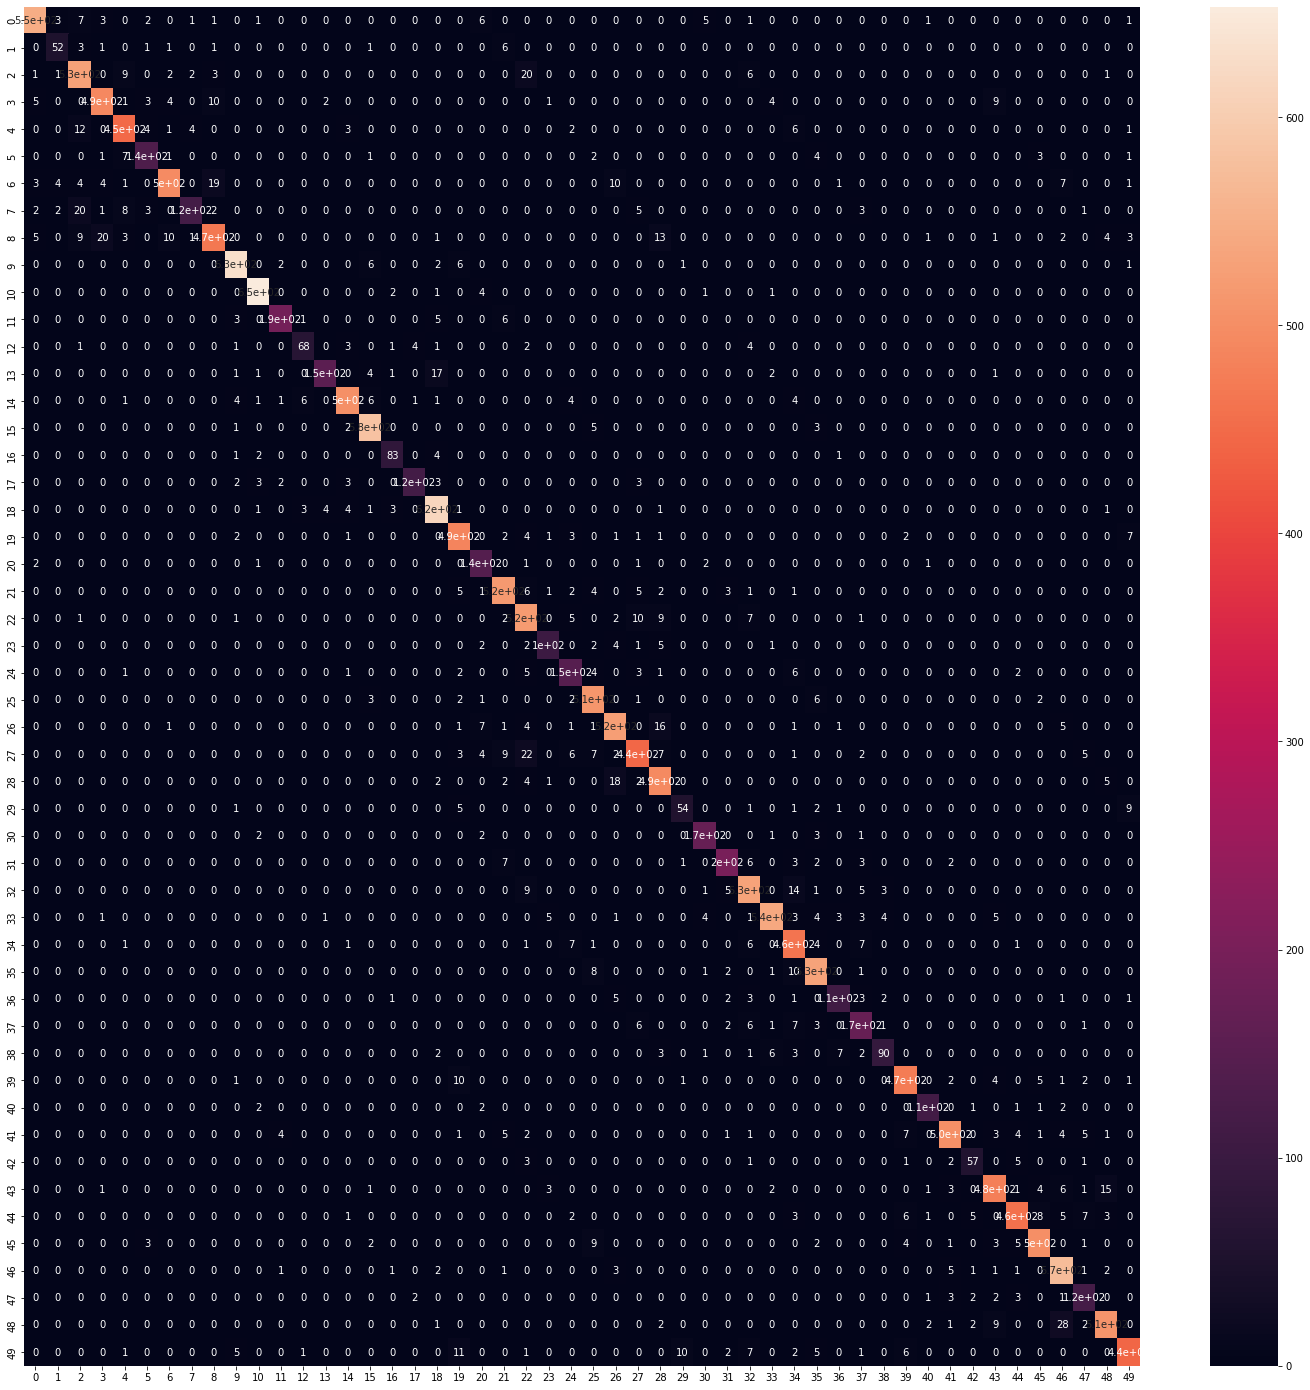

In [ ]:
plt.figure(figsize=(25,25))

CM = confusion_matrix(y_not_one_hot_test, y_not_one_hot_pred_best)
df_cm = pd.DataFrame(CM, index = [i for i in range(50)],
                  columns = [i for i in range(50)])

sn.heatmap(df_cm, annot=True)

In [ ]:
df_evaluate_more_epochs = pd.DataFrame([model_more_epochs.evaluate(X_test, y_test_one_hot), modelR_more_epochs.evaluate(X_test, y_test_one_hot)], columns=model_more_epochs.metrics_names, 
                           index=['not regularized', 'regularized'])
df_evaluate_more_epochs

603/603 [==============================] - 2s 3ms/step - loss: 0.3594 - categorical_accuracy: 0.9270 - precision_10: 0.9368 - recall_10: 0.9212


,loss,categorical_accuracy,precision_9,recall_9
not regularized,0.483305,0.927748,0.929520,0.926866
regularized,0.359402,0.927022,0.936817,0.921208


I think the regularized model with 40 epochs is the best, despite all the models being close when it comes to performance. It is wrong in classification numbers that might look similar (27 and 21), so the source of errors is, as I mentioned before, the handwriting itself. 

## Extra part
After the question I asked on the forum I decided I want to test building a NN which has hidden layer with fewer layers than classes. I will also follow the constrain about 100 000 params.

In [ ]:
n_epochs = 20
model_fewer_neurons = Sequential()

model_fewer_neurons.add(Dense(80, activation='relu', input_shape=(input_size,)))
model_fewer_neurons.add(Dense(40, activation='relu'))

# since we can say that we 15 features 
# first digit from 0 to 4
# second from 0 to 9
# so 16 that migth be enough 
# we expect the network to devide the image
# and recognize two number separatly
model_fewer_neurons.add(Dense(20, activation='relu'))
model_fewer_neurons.add(Dense(40, activation='relu'))

model_fewer_neurons.add(Dense(51, activation='softmax'))

model_fewer_neurons.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_68 (Dense)            (None, 80)                87440     
                                                                 
 dense_69 (Dense)            (None, 40)                3240      
                                                                 
 dense_70 (Dense)            (None, 20)                820       
                                                                 
 dense_71 (Dense)            (None, 40)                840       
                                                                 
 dense_72 (Dense)            (None, 51)                2091      
                                                                 
Total params: 94,431
Trainable params: 94,431
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# all as before to make it fair
model_fewer_neurons.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy', Precision(), Recall()], optimizer='adam')

In [ ]:
history_fewer_neurons = model_fewer_neurons.fit(X_train, y_train_one_hot, validation_split=0.1, epochs=n_epochs, batch_size=64)

Epoch 1/20
1084/1084 [==============================] - 8s 6ms/step - loss: 3.7942 - categorical_accuracy: 0.0735 - precision_8: 0.3003 - recall_8: 0.0081 - val_loss: 2.9483 - val_categorical_accuracy: 0.1551 - val_precision_8: 0.6455 - val_recall_8: 0.0317
Epoch 2/20
1084/1084 [==============================] - 7s 6ms/step - loss: 2.2202 - categorical_accuracy: 0.3457 - precision_8: 0.7323 - recall_8: 0.1782 - val_loss: 1.6324 - val_categorical_accuracy: 0.5191 - val_precision_8: 0.7739 - val_recall_8: 0.3393
Epoch 3/20
1084/1084 [==============================] - 7s 6ms/step - loss: 1.3185 - categorical_accuracy: 0.6143 - precision_8: 0.8048 - recall_8: 0.4572 - val_loss: 1.1601 - val_categorical_accuracy: 0.6633 - val_precision_8: 0.8051 - val_recall_8: 0.5407
Epoch 4/20
1084/1084 [==============================] - 7s 6ms/step - loss: 1.0177 - categorical_accuracy: 0.7068 - precision_8: 0.8280 - recall_8: 0.5971 - val_loss: 0.9910 - val_categorical_accuracy: 0.7203 - val_precision_8

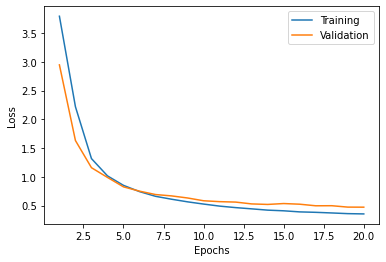

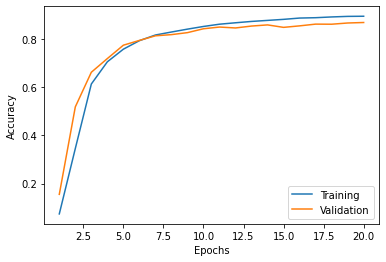

In [ ]:
plot_history(history_fewer_neurons)

In [ ]:
model_fewer_neurons.evaluate(X_test, y_test_one_hot)

603/603 [==============================] - 5s 8ms/step - loss: 0.4762 - categorical_accuracy: 0.8734 - precision_8: 0.9007 - recall_8: 0.8529


[0.4762021005153656,
 0.8733519911766052,
 0.9006796479225159,
 0.8529014587402344]

As we can see it is working. And it doesn't oscillate like the previous model, and obtained better results I will try to learn in more. 

In [ ]:
history_fewer_neurons_2 = model_fewer_neurons.fit(X_train, y_train_one_hot, validation_split=0.1, epochs=n_epochs, batch_size=64)

Epoch 1/20
1084/1084 [==============================] - 6s 5ms/step - loss: 0.3432 - categorical_accuracy: 0.8998 - precision_8: 0.9261 - recall_8: 0.8801 - val_loss: 0.4833 - val_categorical_accuracy: 0.8660 - val_precision_8: 0.8984 - val_recall_8: 0.8456
Epoch 2/20
1084/1084 [==============================] - 6s 5ms/step - loss: 0.3376 - categorical_accuracy: 0.9020 - precision_8: 0.9272 - recall_8: 0.8837 - val_loss: 0.4748 - val_categorical_accuracy: 0.8692 - val_precision_8: 0.8998 - val_recall_8: 0.8474
Epoch 3/20
1084/1084 [==============================] - 5s 5ms/step - loss: 0.3272 - categorical_accuracy: 0.9047 - precision_8: 0.9284 - recall_8: 0.8862 - val_loss: 0.4723 - val_categorical_accuracy: 0.8745 - val_precision_8: 0.8999 - val_recall_8: 0.8560
Epoch 4/20
1084/1084 [==============================] - 6s 6ms/step - loss: 0.3190 - categorical_accuracy: 0.9062 - precision_8: 0.9287 - recall_8: 0.8886 - val_loss: 0.4499 - val_categorical_accuracy: 0.8743 - val_precision_8

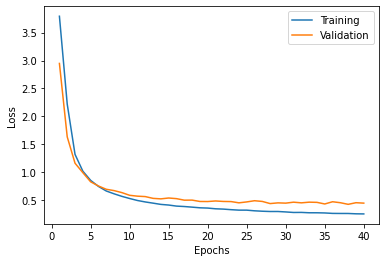

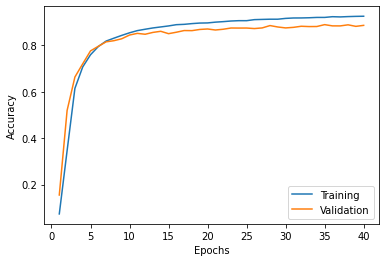

In [ ]:
x_plot = list(range(1, (2 * n_epochs)+1))

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(x_plot, history_fewer_neurons.history['loss'] + history_fewer_neurons_2.history['loss'])
plt.plot(x_plot, history_fewer_neurons.history['val_loss'] + history_fewer_neurons_2.history['val_loss'])
plt.legend(['Training', 'Validation'])

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(x_plot, history_fewer_neurons.history['categorical_accuracy'] + history_fewer_neurons_2.history['categorical_accuracy'])
plt.plot(x_plot, history_fewer_neurons.history['val_categorical_accuracy'] + history_fewer_neurons_2.history['val_categorical_accuracy'])
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

The plot is very stable. It doesn't get any overfitting, so it is definitely better than `model_more_epochs`. Maybe by training it even longer we would obtain better results than the regularised one.

### Appetite comes with eating
I came up with another idea that I want to test. Since the sample can be represented as 20 number vector, what if we instead of one encoding would do encoding customized for this problem? It will be a vector of zeros and ones, but it will have two ones, each representing one digit.

In [ ]:
# I know it is ugly and not easy to understand but it works :)
def customized_hot(number):
  X = np.zeros(15)
  X[number%10 - 1] = 1
  
  index_second = int(((number%100)/10)) + 9
  X[index_second] = 1
  return X

def reverse_customized_hot(customized_hot):
  ones_index = np.where(customized_hot == 1)
  ones_index = ones_index[0]
  # print(ones_index)
  
  return  (ones_index[1] - 9)*10 + ones_index[0] + 1

In [ ]:
y_train_custom = np.array([customized_hot(y) for y in y_train])
y_test_custom = np.array([customized_hot(y) for y in y_test])

In [ ]:
n_epochs=40

In [ ]:
model_custom_out = Sequential()

# little bit more params
# may reduce later
model_custom_out.add(Dense(128, activation='relu', input_shape=(input_size,)))
model_custom_out.add(Dense(64, activation='relu'))
model_custom_out.add(Dense(15, activation='sigmoid'))


model_custom_out.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               139904    
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 15)                975       
                                                                 
Total params: 149,135
Trainable params: 149,135
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_custom_out.compile(loss='binary_crossentropy', metrics=['categorical_accuracy', Precision(), Recall()], optimizer='adam')

In [ ]:
history_custom_out = model_custom_out.fit(X_train, y_train_custom, validation_split=0.1, epochs=n_epochs, batch_size=64)

Epoch 1/40
1084/1084 [==============================] - 6s 5ms/step - loss: 0.1039 - categorical_accuracy: 0.2780 - precision_2: 0.9170 - recall_2: 0.8022 - val_loss: 0.0658 - val_categorical_accuracy: 0.2925 - val_precision_2: 0.9371 - val_recall_2: 0.8872
Epoch 2/40
1084/1084 [==============================] - 5s 4ms/step - loss: 0.0537 - categorical_accuracy: 0.3254 - precision_2: 0.9482 - recall_2: 0.9139 - val_loss: 0.0488 - val_categorical_accuracy: 0.3394 - val_precision_2: 0.9466 - val_recall_2: 0.9253
Epoch 3/40
1084/1084 [==============================] - 5s 4ms/step - loss: 0.0394 - categorical_accuracy: 0.3330 - precision_2: 0.9602 - recall_2: 0.9379 - val_loss: 0.0393 - val_categorical_accuracy: 0.3102 - val_precision_2: 0.9621 - val_recall_2: 0.9337
Epoch 4/40
1084/1084 [==============================] - 5s 5ms/step - loss: 0.0315 - categorical_accuracy: 0.3356 - precision_2: 0.9677 - recall_2: 0.9512 - val_loss: 0.0348 - val_categorical_accuracy: 0.3520 - val_precision_2

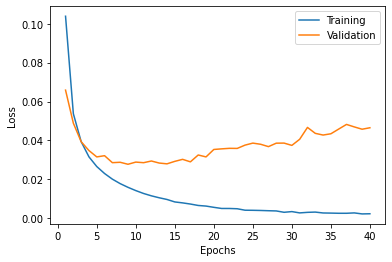

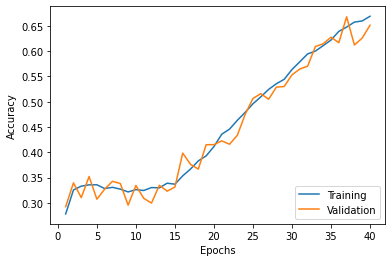

In [ ]:
x_plot = list(range(1,n_epochs + 1))

plot_history(history_custom_out)

In [ ]:
y_custom_pred = model_custom_out.predict(X_test)

603/603 [==============================] - 1s 2ms/step


In [ ]:
def reverse_customized_hot_from_pred(customized_hot):
  return  np.argmax(customized_hot[:9]) + 1 + (np.argmax(customized_hot[10:]) + 1) * 10

In [ ]:
y_pred_digit_custom = np.array([reverse_customized_hot_from_pred(y) for y in y_custom_pred])

In [ ]:
y_pred_digit_custom

array([19, 29, 22, ..., 45, 51, 52])

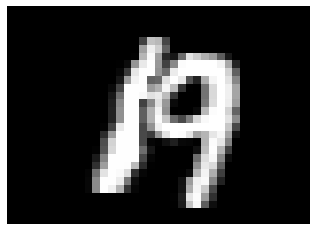

In [ ]:
plot_image(X_test[0].reshape(28,39))

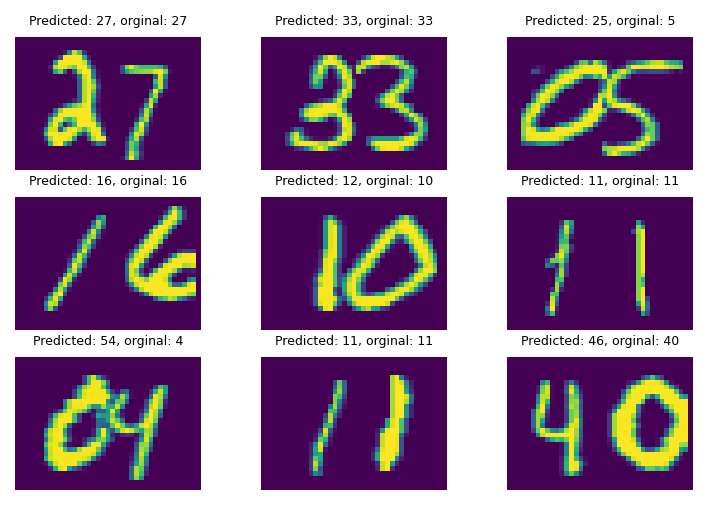

In [ ]:
subplot_images(X_test, y_test, y_pred_digit_custom)

Apparently works!
Not the best results but tuning the hyperparameter may give even better performance.

## Summary
#### Regularazied vs not
Overall the problem wasn't as complicated for the neural network as I expected. Even without regularization, it has done well. However, L2 helped us to obtain slightly better accuracy and prevented huge overfitting. I believe that all the incorrectly qualified pictures would be also hard to qualify by a human, so we can be happy with obtained results. 

About the `model_fewer_layers` it was interesting how it stabilized the loss function and became a sort of protection from overfitting. 

#### Extra part
I have also learned that if we want to try many different models it is a good idea to implement `make_model()` function to make the code more readable, and more compact. For sure I will use this knowledge in the future.

And the last idea was a faliure, but I leave it anyway.

# 2. The development of a simple auto-encoder model  [Mandatory]
Implement a fully-connected AutoEncoder architecuture, with a **compression factor** (ratio between input size and smallest encoding size) in the **range [20-30]**.


Visually investigate the reconstruction abilities of such an architecture, e.g. comparing a few inputs and outputs (reconstructed inputs) of the model (as seen in class).

## 2.1 Building the network

note: although not strictly required, monitoring the training dynamics and performance evaluation is suggested for the autoencoder model.

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

In [ ]:
encoding_dim = 40

# symetrical architecture
# we have endoced dimination equal 40 to fulfill the costraint
# about compresion factor
input = Input(shape=(input_size,))

hidden_1 = Dense(1024, activation = "relu", name = "hidden_1")(input)
hidden_2 = Dense(256, activation = "relu", name = "hidden_2")(hidden_1)
hidden_3 = Dense(128, activation = "relu", name = "hidden_3")(hidden_2)

hidden_4 = Dense(encoding_dim, activation="relu", name = "hidden_4")(hidden_3)

hidden_5 = Dense(128, activation = "relu", name = "hidden_5")(hidden_4)
hidden_6 = Dense(256, activation = "relu", name = "hidden_6")(hidden_5)
hidden_7 = Dense(1024, activation = "relu", name = "hidden_7")(hidden_6)

decoded = Dense(input_size, activation='sigmoid', name = "decoder")(hidden_7)

autoencoder = Model(input, decoded)
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1092)]            0         
                                                                 
 hidden_1 (Dense)            (None, 1024)              1119232   
                                                                 
 hidden_2 (Dense)            (None, 256)               262400    
                                                                 
 hidden_3 (Dense)            (None, 128)               32896     
                                                                 
 hidden_4 (Dense)            (None, 40)                5160      
                                                                 
 hidden_5 (Dense)            (None, 128)               5248      
                                                                 
 hidden_6 (Dense)            (None, 256)               3302

In [ ]:
# we don't need any metrics, 
autoencoder.compile(loss='mse', optimizer='adam')

In [ ]:
autoencoder_history = autoencoder.fit(flatten_X, flatten_X, validation_split=0.1, epochs=32, batch_size=128)

Epoch 1/32
678/678 [==============================] - 45s 66ms/step - loss: 0.0484 - val_loss: 0.0299
Epoch 2/32
678/678 [==============================] - 42s 62ms/step - loss: 0.0265 - val_loss: 0.0237
Epoch 3/32
678/678 [==============================] - 42s 62ms/step - loss: 0.0222 - val_loss: 0.0208
Epoch 4/32
678/678 [==============================] - 42s 62ms/step - loss: 0.0199 - val_loss: 0.0194
Epoch 5/32
678/678 [==============================] - 42s 61ms/step - loss: 0.0183 - val_loss: 0.0176
Epoch 6/32
678/678 [==============================] - 42s 61ms/step - loss: 0.0171 - val_loss: 0.0169
Epoch 7/32
678/678 [==============================] - 42s 61ms/step - loss: 0.0162 - val_loss: 0.0160
Epoch 8/32
678/678 [==============================] - 44s 65ms/step - loss: 0.0154 - val_loss: 0.0155
Epoch 9/32
678/678 [==============================] - 41s 61ms/step - loss: 0.0148 - val_loss: 0.0150
Epoch 10/32
678/678 [==============================] - 41s 61ms/step - loss: 0.014

## 2.2 Visually Inspecting the results 

Investigate the reconstruction capabilities of autoencoders by comparing (in a multi-column plot) the visual representation of some input data (5 to 10 samples) with the reconstruction of such samples (output of the autoencoder).

In [ ]:
def encoder_plot(X_real, X_pred = None, n_images=7):
  indecies = np.random.randint(X_real.shape[0], size=n_images)
  fig, axs = plt.subplots(n_images, 2)

  fig.set_dpi(200)

  for i in range(n_images):
    index = indecies[i]
    axs[i, 0].imshow(X_real[index].reshape(28,39))
    axs[i, 1].imshow(X_pred[index].reshape(28,39))
    
    axs[i, 0].axis('off')
    axs[i, 1].axis('off')

In [ ]:
X_pred = autoencoder.predict(flatten_X)

3011/3011 [==============================] - 30s 10ms/step


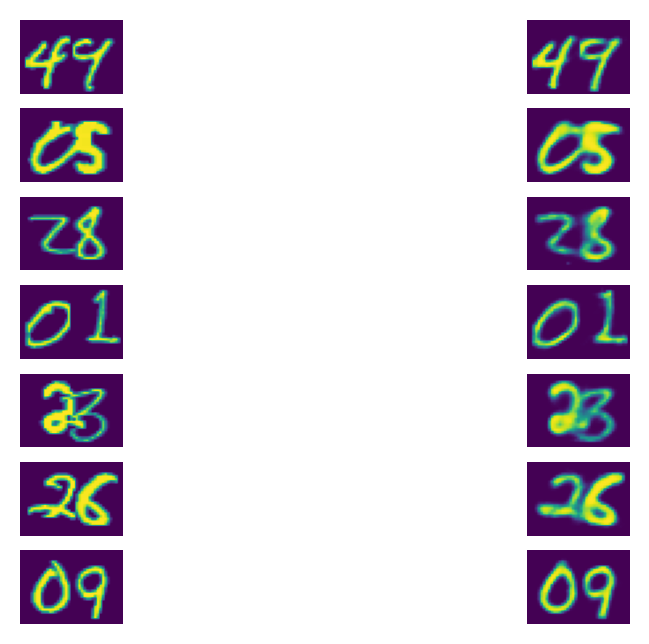

In [ ]:
encoder_plot(flatten_X, X_pred)

It reconstructs all the images very well. They are a bit blurry, but it is a common thing when it comes to autoencoder. Even with fewer parameters and epochs, it was obtaining similar results.

## 2.3 Generate new samples

Starting from random encodings, generate $N$ ($N \in [10,20]$) new samples, and make some comments about the quality and distribution of the generated samples.

In [ ]:
decoder = Model(hidden_4, decoded)

In [ ]:
n_gen = 17
to_generate = np.random.rand(n_gen, encoding_dim)

In [ ]:
decoder.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 40)]              0         
                                                                 
 hidden_5 (Dense)            (None, 128)               5248      
                                                                 
 hidden_6 (Dense)            (None, 256)               33024     
                                                                 
 hidden_7 (Dense)            (None, 1024)              263168    
                                                                 
 decoder (Dense)             (None, 1092)              1119300   
                                                                 
Total params: 1,420,740
Trainable params: 1,420,740
Non-trainable params: 0
_________________________________________________________________


In [ ]:
X_gen = decoder.predict(to_generate)

1/1 [==============================] - 0s 52ms/step


(-0.5, 38.5, 27.5, -0.5)

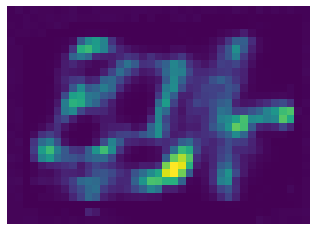

In [ ]:
plt.imshow(X_gen[0].reshape(28,39))
plt.axis('off')

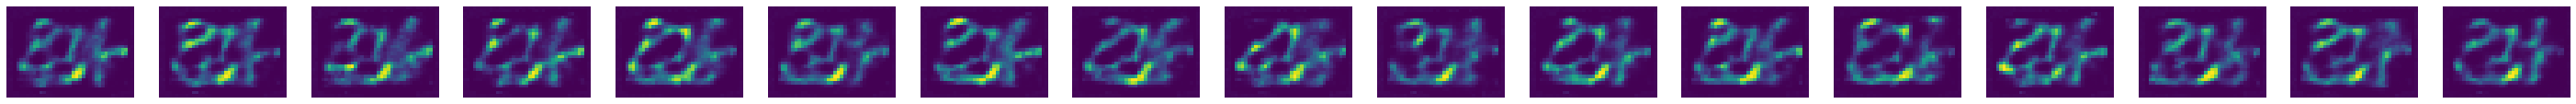

In [ ]:
fig, axs = plt.subplots(1, n_gen, figsize=(50, n_gen*50))
for i, x in enumerate(X_gen):
  axs[i].imshow(x.reshape(28,39))
  axs[i].axis('off')

That is why I increased the complexity of the model to obtain better results here. Even with many tries and approaches, I didn't succeed. The pictures don't represent any number. We can find some shapes that one could find similar to numbers, but we can't say what number it is, rather many digits at the same time. I think the encoder should be way more complex to obtain satisfying results.

# 3. [OPTIONAL] The use and evaluation of the latent (encoded) representations generated by the auto-encoder to solve the problem of supervised classification.

1. Obtain `X_train_encoded`, `X_test_encoded`, the latent (encoded) representations of `X_train` and `X_test` generated by the (encoder module of the) autoencoder developed in Section 2.

2. With the use of any classic machine learning method of your choice (avoid NNs), classify letters as in Sec.1 based on this representation.

3. Apply the same type of ML algorithm chosen in pt.2, but directly on the original data `X_train`, `X_test` (or you can use suitable dimensionality reduction methods if the chosen algorithm is known to require them or benefit from them).  

4. Compare (briefly) the performances on the test set, between the best model of Sec.1, the ML model trained on `X_train_encoded` and the ML model trained on `X_train` (or any other suitable representation that you choose in pt.3).


In other words, instead of feeding images directly through a classifier, you can try to use the encoded representations from the AE as input for a classic ML algorithm (XGB, SVM, RF ...) to solve the classification task.


In [ ]:
encoder = Model(input, hidden_4)

In [ ]:
X_test_reduced = encoder.fit(X_test)
X_train_reduced = encoder.fit(X_train)

In [ ]:
from sklearn.svm import SVC

clf = SVC()

clf.fit(X_train, y_train)

I exceeded GPU usage so I want be able to do it :/